# WATER BAG PREDICTION - Preliminary Model Evaluation

#### Notebook Sections:
1. Baseline model
2. Multiple models
3. Time Series Split + Undersample Pipeline: Compare sith and without undersampling

---
## Define Functions

#### Change project root directory

In [2]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [3]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample, groupSplitGridSearch
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

#### Imbalanced preprocessing & learning modules
from scipy.stats import loguniform
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

#### Preprocessing & machine learning modules
from sklearn.utils import all_estimators
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, GridSearchCV

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

#### Metrics and scoring functions
from sklearn.metrics import (
    make_scorer, recall_score, precision_score,
    f1_score, precision_recall_fscore_support,
    classification_report as cr
)

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_0 = make_scorer(f1_score, pos_label=0)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-0': f1_0, 'f1-1': f1_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Custom functions

#### Select and split target from dataset

In [4]:
def select_target(target_id, periods_ahead=4, report=True):

    print(f'Selected target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    if report: display(Y.value_counts().to_frame('Target'))

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')
        if report: display(Y.value_counts().to_frame('Transformed Target'))

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)

    # Target validation split
    yt = Y.loc[xt.index]
    ye = Y.loc[xe.index]
    groups_train = groups.loc[xt.index]
    groups_eval = groups.loc[xe.index]

    ### Validation statistics
    if report: split_report(Y, yt, ye)
        
    return Y, yt, ye, groups, groups_train, groups_eval

#### Cross validate undersample pipeline

In [5]:
def undersample_cross_validation(model, train_prct):
    # undersample pipeline
    if train_prct=='natural': train_prct = yt.mean() / (1 - yt.mean())
    steps = [
        ('under', RandomUnderSampler(sampling_strategy=train_prct, random_state=0)),
        ('model', model)
    ]; pipe = Pipeline(steps=steps)
    # cross-validation split
    cv_group = splitter.split(xt, yt, groups_train, strategy)
    # evaluate splits
    return pd.DataFrame(cross_validate(
        pipe, xt, yt, groups=groups_train,
        scoring=scoring, cv=cv_group,
        n_jobs=-1, verbose=5,
        pre_dispatch='2*n_jobs',
        return_train_score=True,
    ))

---
## Load & Preprocess Data

In [6]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data.drop('index', 1)
Yi = project.time_serie.drop('-1', 1)
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

# Project and model deployment paths
path_project = 'API Deploy/'
path_models = 'API Deploy/Modelos/'

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()
<ipython-input-6-5c17a6a6667a>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = project.data.drop('index', 1)
<ipython-input-6-5c17a6a6667a>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Yi = project.time_serie.drop('-1', 1)


---
# Feature and target selection

### Feature set

In [7]:
train_start, train_end = '2018-06', '2021-10'
eval_start, eval_end = '2021-11', '2022-04'

transform_args = dict(
    scale=True, interpolate='linear', fillna='min'
)

# Select feature set
X = TimeseriesTransformPipeline(
    data, train_start, cut=-1,
    drop_empty_cols=True,
    **transform_args,
    label_encode=data.columns[:11]
); X = X[: eval_end]

# Validation split
xt = X[: train_end]
xe = X[eval_start: eval_end]

Initial data: (437875, 241)
Time extraction: (142866, 241)


C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\timeserie_transform.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X.dropna(1, how='all', inplace=True)


Drop empty columns:  (142865, 228)


### Save feature set deployment information

In [ ]:
# Select raw feature set for preprocessing
X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
    data, train_start, cut=-1,
    drop_empty_cols=True, scale=False,
    interpolate=None, fillna=None
); X_raw = X_raw[: eval_end]

# Save Features description
if path_project is not None:
    X_info = X_raw.describe().loc[['min', 'max', 'mean']].T
#     X_info.to_csv(path_project + 'deploy_info.csv', index=True)

### Pipeline & target loop parameters

In [8]:
seed = 0
periods_ahead = 4

LinearSVC = classifiers['LinearSVC']
model = LinearSVC(C=1.0, random_state=seed)

splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_size=0.79, test_size=0.20, # Not used if minority split strategy is GroupKFold
    train_prct=None, test_prct='natural',
    random_state=seed,
)
strategy='GroupKFold'

---
# Multi-target cross validation

In [9]:
scr_cols = ['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1']

### Multi-target split evaluation loop

In [100]:
first_target = 0
# train_prct = 'natural'
train_prct = 0.025
score_path = f'Modelagem de Bolsões/Scores/Multi-Target KFold - {train_prct}/score-{"{}"}.csv'

target_results = []
for i, target_id in enumerate(Yi.columns[first_target:]):
    # print progress
    co(wait=True); print('\n', f'Targets evaluated: {target_id}/{Yi.shape[1]}', '\n')
    # select target
    Y, yt, ye, groups, groups_train, groups_eval = select_target(target_id, periods_ahead, report=False)
    # cross-validation split
    try:
        score = undersample_cross_validation(model, train_prct)
        score['target_id'] = target_id
    except:
        continue
    # save score
    score.to_csv(score_path.format(target_id), index=False)
    # keep score
    target_results.append(score)


 Targets evaluated: 82/79 

Selected target: Estrada da Pedra - id: 82 



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


### Reload and visualize result

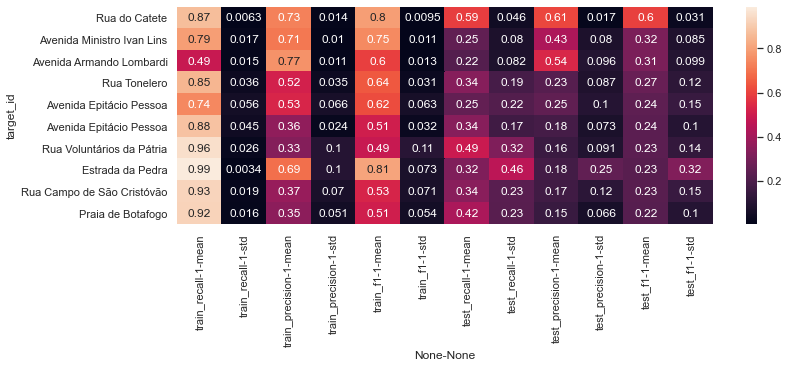

In [117]:
score_path = 'Modelagem de Bolsões/Scores/Multi-Target KFold - 0.025/score-{}.csv'

target_results = []
for _id in Yi.columns:
    try:
        target_results.append(pd.read_csv(score_path.format(_id)))
    except: continue
scores = pd.concat(target_results)

scr_stats = scores.groupby('target_id')[scr_cols].agg([np.mean, np.std]).sort_values(('test_f1-1', 'mean'), ascending=False).head(10)
scr_stats.index = scr_stats.index.map(target_names)

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.heatmap(scr_stats.head(10), annot=True)
# print(scr_stats.head(10).index.map(target_names).values)

---
# Time Series Split

In [12]:
from sklearn.model_selection import TimeSeriesSplit
target_id = '1'
periods_ahead = 4

# select target
Y, yt, ye, groups, groups_train, groups_eval = select_target(target_id, periods_ahead, report=False)

Selected target: Rua do Catete - id: 1 



### Model pipeline & target loop parameters

In [142]:
seed = 0
train_prct = 0.025
natural_prct = yt.mean() / (1 - yt.mean())

LinearSVC = classifiers['LinearSVC']
model = LinearSVC(C=1.0, random_state=seed)

n_months = Y.resample('M').mean().shape[0] * 2
splitter = TimeSeriesSplit(n_splits=5, test_size=None)

In [143]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.kernel_based import RocketClassifier

model = TimeSeriesForestClassifier(
    min_interval=5,
    n_estimators=5,
    n_jobs=-1,
    random_state=0,
)

model = RocketClassifier(
    num_kernels=5,
    rocket_transform='rocket',
    max_dilations_per_kernel=32,
    n_features_per_kernel=4,
    use_multivariate='auto',
    n_jobs=-1,
    random_state=0,
)

### Time split cross-validation

In [ ]:
# cross-validation split
cv_time = list(splitter.split(X, Y))

# undersample pipeline

rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=0)

pipe = Pipeline([('under', rus), ('model', model)])

# evaluate splits
score = pd.DataFrame(cross_validate(
    pipe, X.values, Y.values, # groups=groups_train,
    scoring=scoring, cv=cv_time,
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
    return_train_score=True,
    error_score=np.nan
))

test_start = []
for train, test in cv_time:
    test_start.append(X.iloc[test].index.min())
score.index = test_start

### Temporal performance

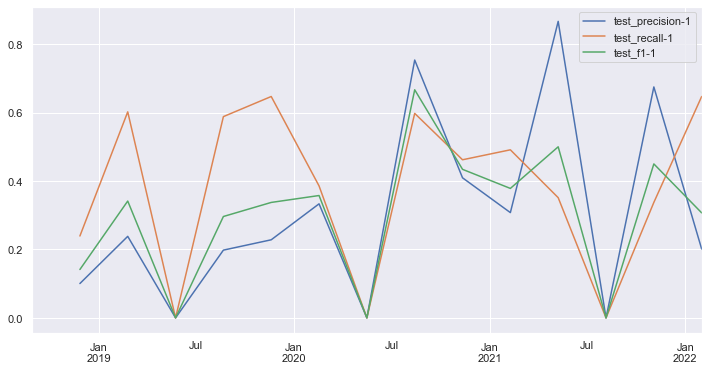

In [126]:
month_mean = Y.resample('M').mean().shift().to_frame('Normalized Month Average')
month_mean.iloc[:, 0] = mms().fit_transform(month_mean)

fig, ax = plt.subplots(figsize=(12, 6))
score[scr_cols[3:6]].plot(marker=None, ax=ax)
# ax = month_mean.plot(ax=ax, linestyle='--')

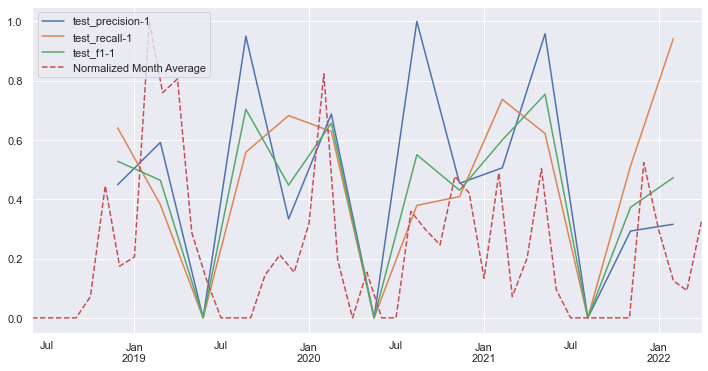

In [132]:
month_mean = Y.resample('M').mean().to_frame('Normalized Month Average')
month_mean.iloc[:, 0] = mms().fit_transform(month_mean)

fig, ax = plt.subplots(figsize=(12, 6))
score[scr_cols[3:6]].plot(marker=None, ax=ax)
ax = month_mean.plot(ax=ax, linestyle='--')

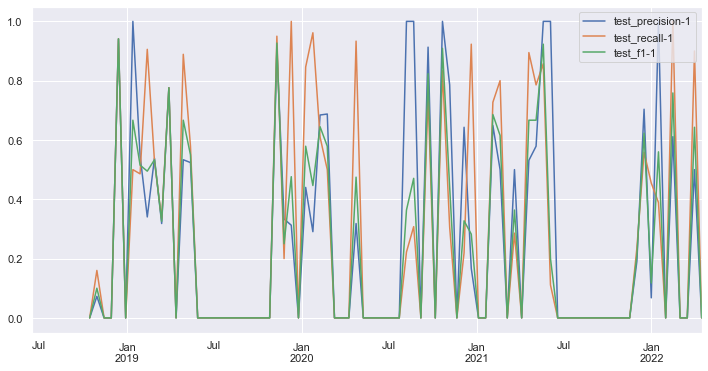

In [48]:
month_mean = Y.resample('M').mean().shift().to_frame('Normalized Month Average')
month_mean.iloc[:, 0] = mms().fit_transform(month_mean)

fig, ax = plt.subplots(figsize=(12, 6))
score[scr_cols[3:6]].plot(marker=None, ax=ax)
# ax = month_mean.plot(ax=ax, linestyle='--')

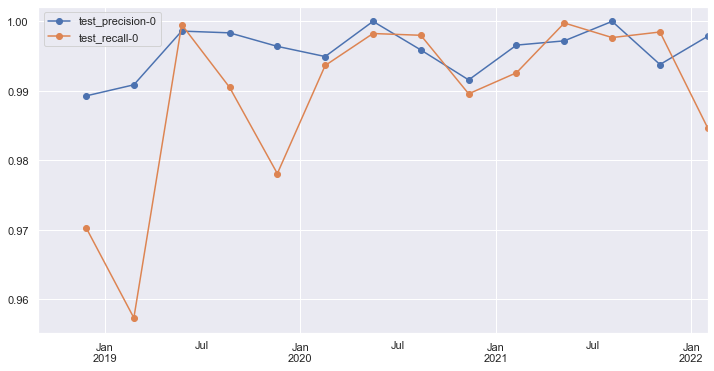

In [127]:
month_mean = Y.resample('M').mean().shift().to_frame('Normalized Month Average')
month_mean.iloc[:, 0] = mms().fit_transform(month_mean)

fig, ax = plt.subplots(figsize=(12, 6))
score[['test_precision-0', 'test_recall-0']].plot(marker='o', ax=ax)
# ax = month_mean.plot(ax=ax, linestyle='--', marker='.')

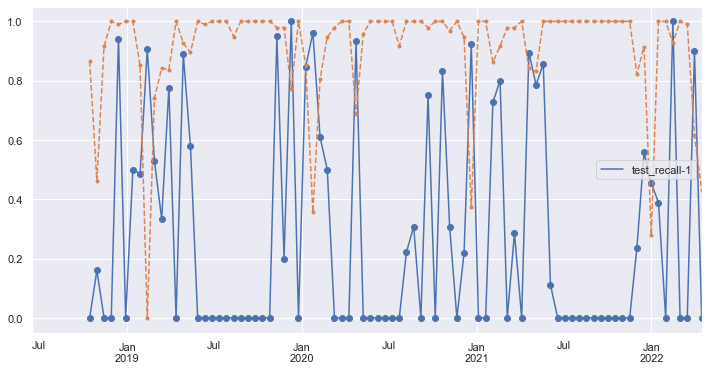

In [50]:
prec_pos_norm = pd.Series(mms().fit_transform(score[['test_recall-0']]).reshape(-1), index=score.index, name='test_recall-0 (normalized)')

fig, ax = plt.subplots(figsize=(12, 6))
score[['test_recall-1']].plot(marker='o', ax=ax)
ax = prec_pos_norm.plot(ax=ax, linestyle='--', marker='.')

### General performance

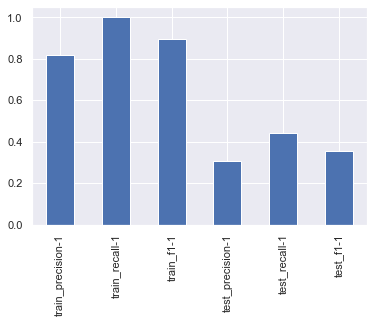

In [120]:
score[score['test_recall-1']!=0].mean()[scr_cols].plot.bar()

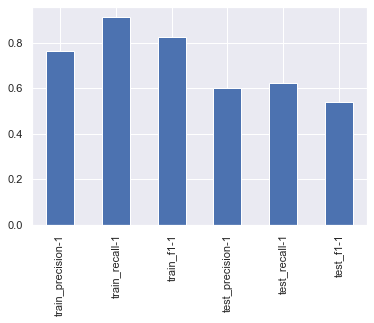

In [55]:
score[score['test_recall-1']!=0].mean()[scr_cols].plot.bar()

### Validation performance

In [68]:
rus = RandomUnderSampler(sampling_strategy=0.02, random_state=0)

pipe = Pipeline([('under', rus), ('model', model)])

pipe.fit(xt, yt)

print(cr(ye, pipe.predict(xe)))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     17245
         1.0       0.37      0.64      0.47       131

    accuracy                           0.99     17376
   macro avg       0.68      0.82      0.73     17376
weighted avg       0.99      0.99      0.99     17376



c:\Users\luisr\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


---
# Time Serie Classification

In [10]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

In [107]:
rus = RandomUnderSampler(sampling_strategy=0.02, random_state=0)

pipe = Pipeline([('under', rus), ('model', model)])

ts_model = TimeSeriesForestClassifier(
    min_interval=2,
    n_estimators=5,
    n_jobs=-1,
    random_state=0,
)

In [108]:
ts_model.fit(xt.values, yt.values)

TimeSeriesForestClassifier(min_interval=2, n_estimators=5, n_jobs=-1,
                           random_state=0)

In [102]:
yprob = ts_model.predict_proba(xe.values)[:, 1]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C05864EAC0>,
      dtype=object)

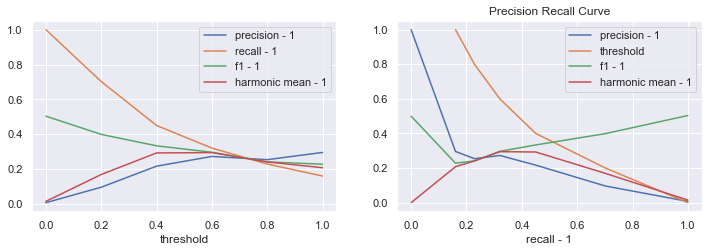

In [103]:
precision_recall_plot(ye, yprob)

In [90]:
print(cr(ye, ts_model.predict(xe.values)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17245
         1.0       0.43      0.42      0.43       131

    accuracy                           0.99     17376
   macro avg       0.71      0.71      0.71     17376
weighted avg       0.99      0.99      0.99     17376



In [58]:
print(cr(ye, ts_model.predict(xe.values)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17245
         1.0       0.43      0.42      0.43       131

    accuracy                           0.99     17376
   macro avg       0.71      0.71      0.71     17376
weighted avg       0.99      0.99      0.99     17376



In [61]:
print(cr(ye, ts_model.predict(xe.values)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17245
         1.0       0.46      0.37      0.41       131

    accuracy                           0.99     17376
   macro avg       0.73      0.68      0.70     17376
weighted avg       0.99      0.99      0.99     17376



### Probability visualization

In [ ]:
cross_val_predict?